# 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from tabulate import tabulate
from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
import random 

### 0.1. Helper functions

In [2]:
#função corrigida
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

#função que calcula a performance dos modelos
def ml_error(model_name, y, yhat):
    """model_name: nome do modelo
       y:valores reais
       yhat: valores preditos/ estimativas
    """
    #calculo de 3 tipos de erros:
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    #lista para calcular a performance 
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #data inicio da validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        #data fim da validação
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        #filtrando o dataset para pegar os dados de treino (que começam do inicio ate os dados de validação)
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #dataset de treino e validação
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation= validation['sales']

        #model
        m = model.fit( xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #guardando a performance de cada iteração
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)
                        }, index=[0])

### 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\train.csv', low_memory=False)

df_store_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\store.csv', low_memory=False)

In [4]:
#merge dos dois dfs
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 - PASSO 1 - Descrição dos dados

In [5]:
#copia dos dados originais para ficar tipo como um backup
df1 = df_raw.copy()

### 1.1. Rename columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#função que deixa tudo minusculo e separado por _
snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

### 1.2. Data dimensions

In [8]:
print('N° de linhas: {}'.format(df1.shape[0]))
print('N° de colunas {}'.format(df1.shape[1]))

N° de linhas: 1017209
N° de colunas 18



### 1.3. Data types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [11]:
#quantidade de células vazias
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Preenchendo o NA

In [12]:
#CompetitionDistance - distance in meters to the nearest competitor store
#vou assumir que se o valor é mt maior que a distância máxima que tem um competidor proximo então é a msm coisa que dizer que não tem um competidor proxim

max_value = df1['competition_distance'].max()
#isnan avalia se é NA
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

In [13]:
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#vou assumir que é vazio pqe não tem um competidor mais proximo ou tem um competidor proximo mas não temos info de quando abriu
#vou substituir pelo mês da data da venda

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [14]:
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [15]:
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
#dict para trocar o num pelo nome do mês
month_map = {1: 'Jan',
             2: 'Fev',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sept',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

#susbtitui o N/A por zero
df1['promo_interval'].fillna(0, inplace=True)

#extraindo o mês da data e aplicando o dicionario para fazer a tradução
df1['month_map'] = df1['date'].dt.month.map(month_map)

#avaliação se o month_map está dentro do intervalo para ver se a loja está na promoção (1) ou não (0)
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
#quantidade de células vazias
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
#passando para inteiro
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Estatísticas descritivas

- Métricas de tendência central: média e mediana
- Métricas de dispersão: desvio padrão, max, min e range, skew e kurtosis

In [19]:
#separando os atributos numéricos
num_attributes = df1.select_dtypes( include = ['int64','int32','float64'])

#separando os atributos categóricos
cat_attributes = df1.select_dtypes( exclude = ['int64','int32','float64','datetime64[ns]'])

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7.1 Atributos numéricos

In [21]:
#media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#desvio padrão, max, min e range, skew e kurtosis
std = pd.DataFrame(num_attributes.apply( np.std )).T
min_ = pd.DataFrame(num_attributes.apply( min )).T
max_ = pd.DataFrame(num_attributes.apply( max )).T
range_ = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
skew = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
kurtosis = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenando
m = pd.concat([min_, max_, range_, ct1, ct2, std, skew, kurtosis]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [22]:
sns.set(rc={'figure.figsize':(10,5)})

C:\Users\laais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

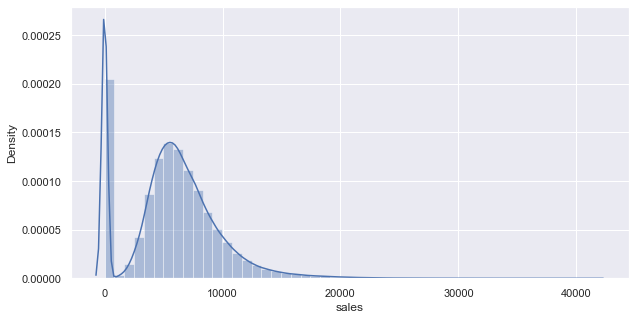

In [23]:
sns.distplot(df1['sales'])

C:\Users\laais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

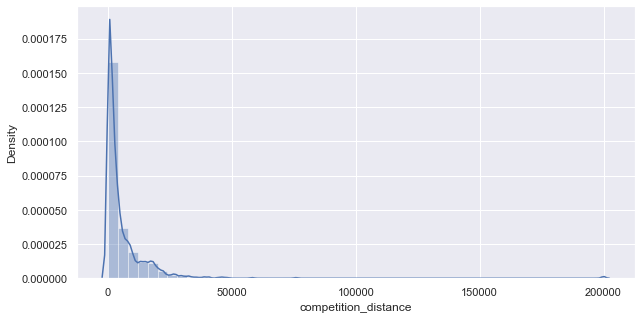

In [24]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Atributos categóricos

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

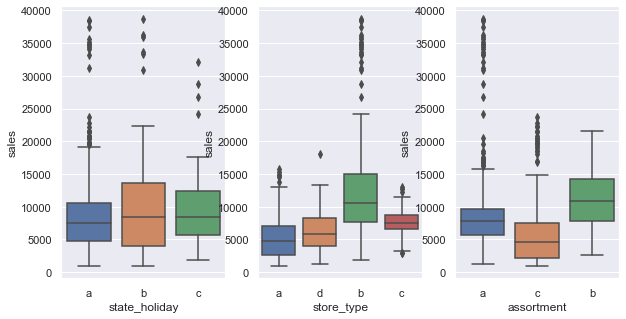

In [26]:
#filtrando os dias não tem feriado e que tem venda maior q 0
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)        

# 2.0 - PASSO 2 - Feature Engineering

In [27]:
df2 = df1.copy()

## 2.1 Mapa Mental

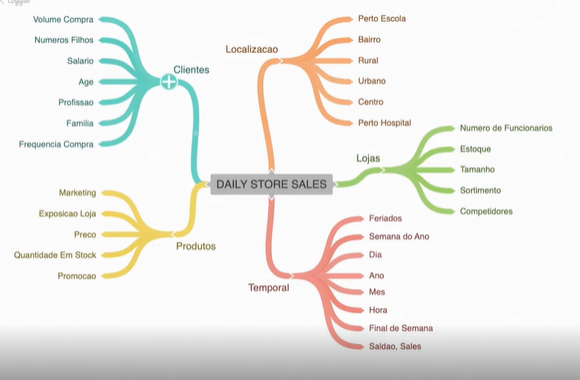

In [28]:
Image('mapa.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menor.

**5.** Lojas com maior maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais proximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que tem entram mais nos feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.


## 2.3 Lista final de hipóteses

(Sugestão de priorização de hipóteses: escolha hipóteses em que você já tem o dado disponível naquele momento)

**1**. Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

Feature Engineering refere-se ao processo de usar o conhecimento do domínio para selecionar e transformar as variáveis mais relevantes dos dados brutos

In [29]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [30]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#cometition since
#datetime.datetime() é uma função que monta uma data apartir de valores
df2['competion_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis=1)
df2['competion_time_month'] = ((df2['date'] - df2['competion_since'])/30 ).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#assortment
#Assortment - describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
#StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\laais\AppData\Local\Temp/ipykernel_11944/2515139808.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - PASSO 3 - Filtragem de variáveis

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competion_since,competion_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [34]:
#só vou usar as vendas em que open é diferente de zero
#sellers tem que ser maior que zero

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [35]:
#baseado no contexto, não vamos ter a coluna customers no momento da previsão pqe não tem como prever quantos clientes vai ter no dia
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - PASSO 4 - Análise Exploratória dos Dados

In [36]:
df4 = df3.copy()

In [37]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competion_since,competion_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Análise Univariada

### 4.1.1 Response Variable

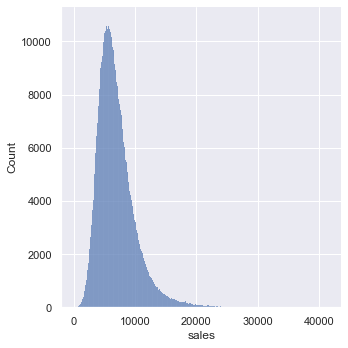

In [38]:
#a variavel resposta é a sales
sns.displot(df4['sales'])

É importante avaliar a variável resposta porque a maioria dos algoritmos de Machine Learning são criados baseados em algumas premissas, ou seja, baseado em alguns comportamentos do ambiente. 

Uma dessas premissas é que os dados sejam independentes e que sigam uma distribuição normal. Quanto mais normal for a variável resposta, melhor seu algoritmo vai performar. 

Existem algumas técnicas para transformar a sua variável resposta mais próxima possível na distruição normal. 

### 4.1.2 Numere Variable

In [39]:
num_attributes.head().T

,0,1,2,3,4
store,1.0,2.0,3.0,4.0,5.0
day_of_week,5.0,5.0,5.0,5.0,5.0
sales,5263.0,6064.0,8314.0,13995.0,4822.0
customers,555.0,625.0,821.0,1498.0,559.0
open,1.0,1.0,1.0,1.0,1.0
promo,1.0,1.0,1.0,1.0,1.0
school_holiday,1.0,1.0,1.0,1.0,1.0
competition_distance,1270.0,570.0,14130.0,620.0,29910.0
competition_open_since_month,9.0,11.0,12.0,9.0,4.0
competition_open_since_year,2008.0,2007.0,2006.0,2009.0,2015.0


In [40]:
df1['customers'].max()

7388

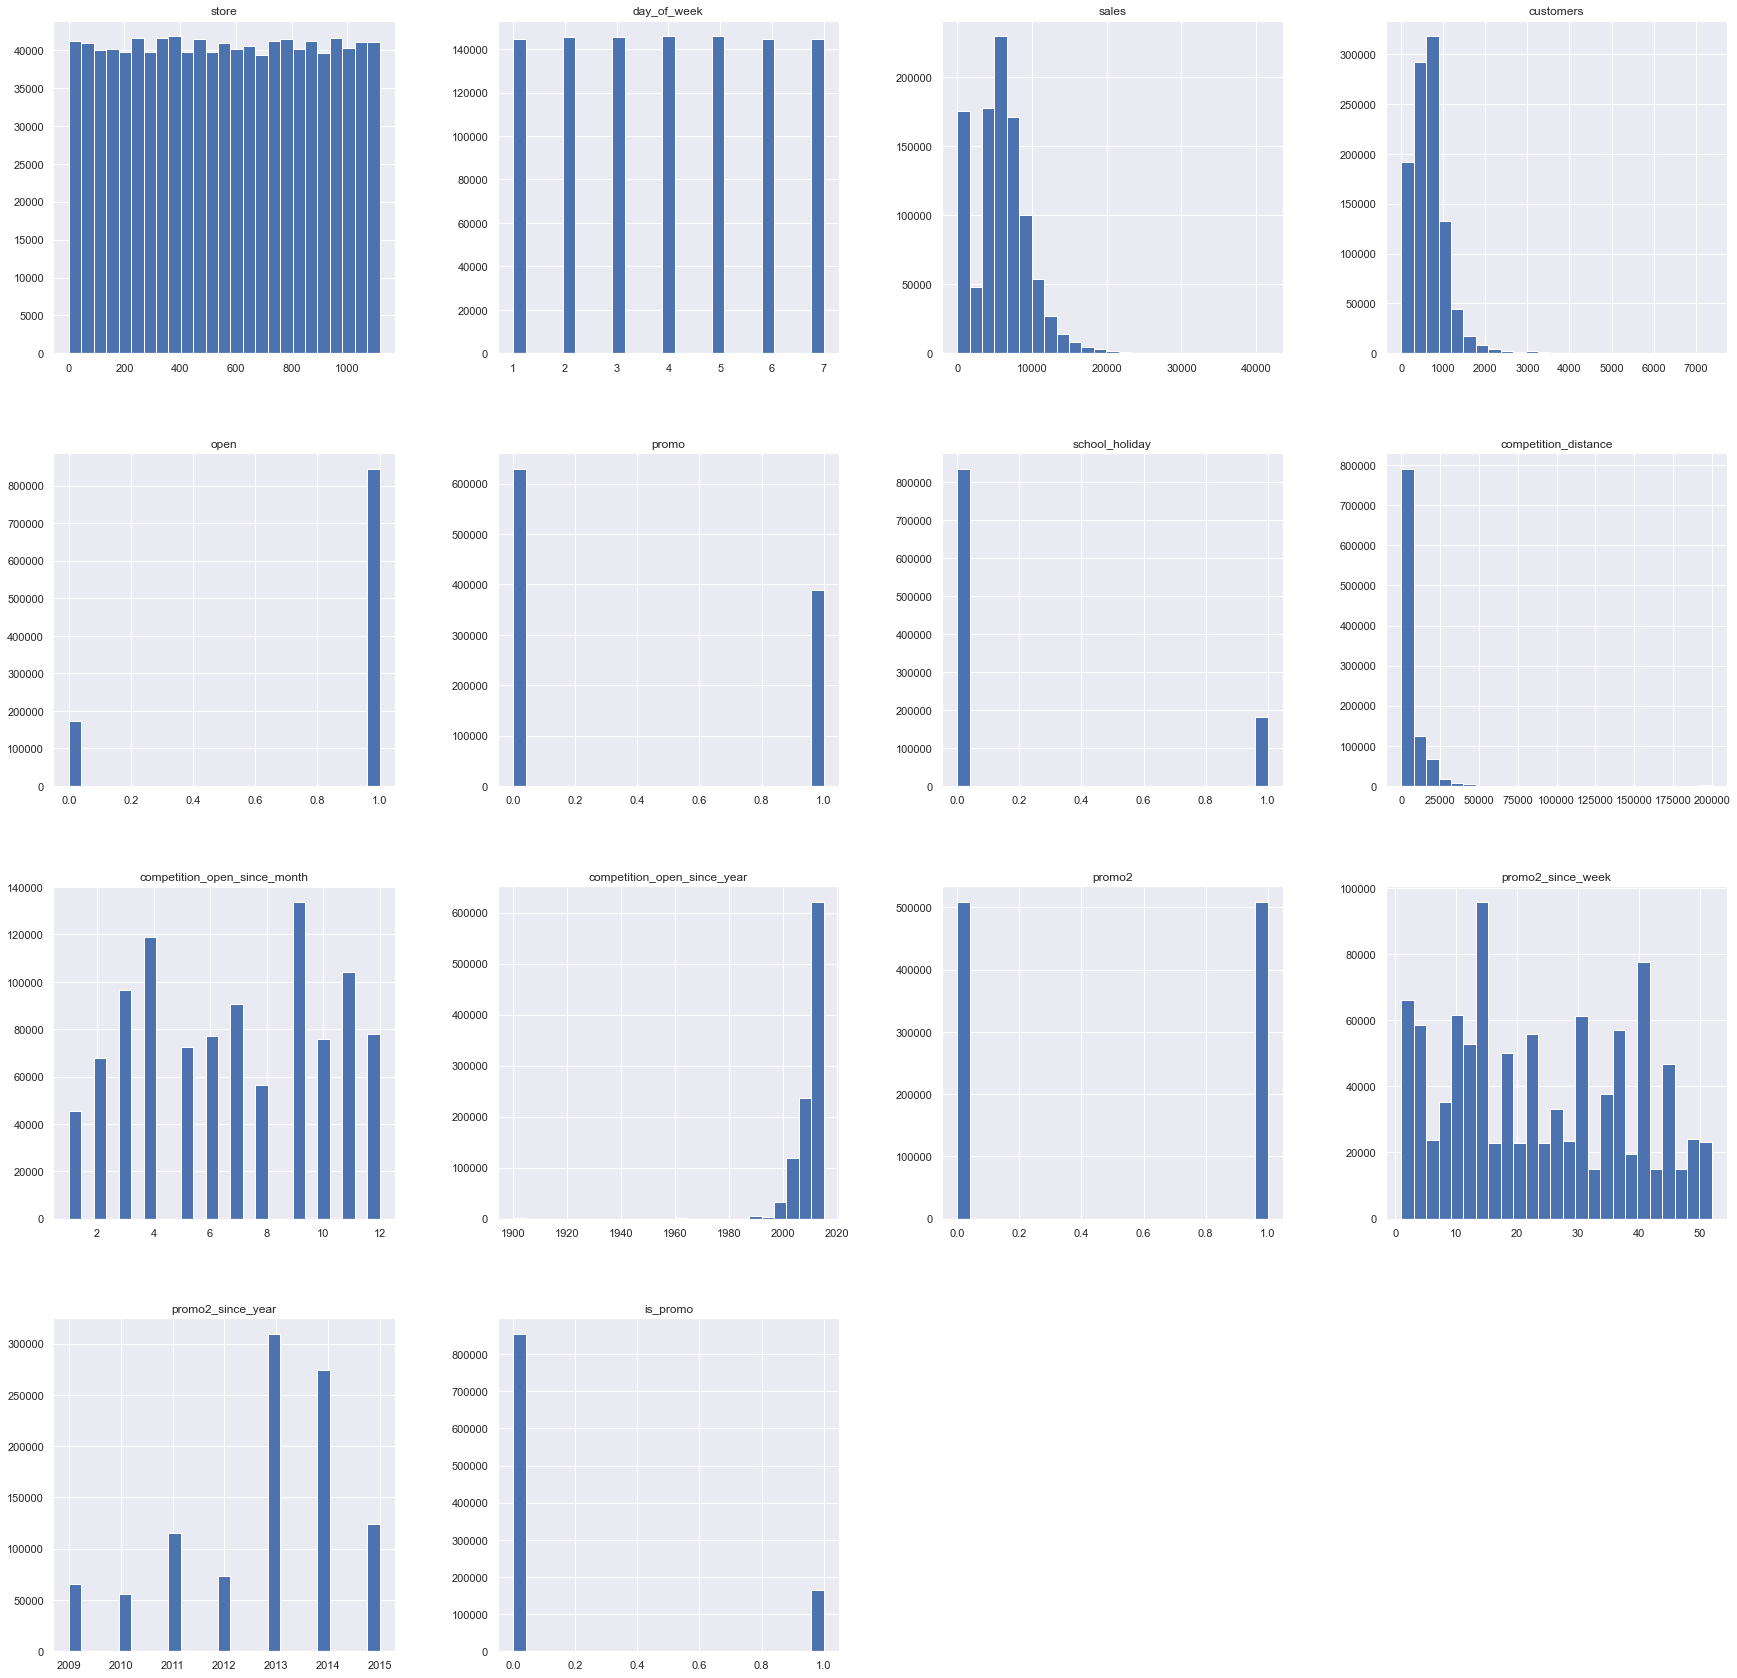

In [41]:
num_attributes.hist(bins=25,figsize=[30,30],layout =[4,4]);

Analisando os gráficos é possível perceber que:

- **is_promo** (se tem promoção (1) ou não (0)) tem mais vendas quando não tem promoção do que quando tem. 

- **promo2_since_year** (ano em que a promoção consecutiva começou) em 2013 e em 2014 teve mais promoçãos consecutivas

- **promo2_since_week** (semana em que a promoção consecutiva começou) 

- **promo2** (se a promoção é contínua e consecutiva) o número de vendas se a promoção continuou ou não é bem proximo.

- **competition_open_since_year** (ano aproximado que o competidor inaugurou) As lojas em sua maioria inauguraram depois de 2000, tendo uma concentração maior em 2014. 

- **competition_open_since_month** (mês aproximado que o competidor inaugurou) As lojas inauguraram com mais frequência em abril e em novembro. Tem um comportamento interessante.   

- **competition_distance** (distância até outro competidor) Existe uma alta concentração de competidores com uma distância pequena, ou seja existem mais competidores mais próximos das lojas do que longe. 

- **school_holiday** (indica se a loja foi afetada pelo feriado das escolas) a maioria das lojas não são afetadas pelos feriados escolares

- **promo** (indicador se tem promoção no dia) tem mais vendas quando não tem promoção do que quando tem. 

- **open** (indicador se a loja ta aberta) não tem um comportamento relavante porque obviamente a loja vai vender mais se estiver aberta. 

- **customers** (n° de clientes por dia) nos primeiros dias tem mais clientes (???)

- as vendas (**sales**) seguem uma distribuição próxima da normal, tem alta kutosis e Skewness positiva (deslocamento a esquerda);

- **day_of_week** não tem um comportamento relevante, ou seja, o dia da semana não impacta nas vendas. Tem baixa kurtosis, tem a mesma chance de tudo acontencer;

- **store** (ID da loja) não tem um comportamento relavante.

### 4.1.3 Categorical Variable

In [42]:
cat_attributes.head().T

,0,1,2,3,4
state_holiday,0,0,0,0,0
store_type,c,a,a,c,a
assortment,a,a,a,c,a
promo_interval,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,0
month_map,Jul,Jul,Jul,Jul,Jul


In [43]:
#state_holiday
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

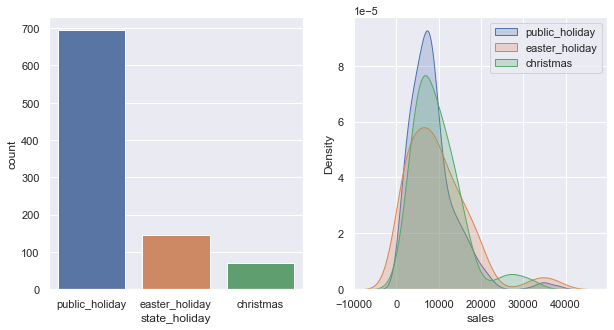

In [44]:
#state_holiday
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])


plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True)
plt.legend(labels=["public_holiday","easter_holiday","christmas"])

In [45]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


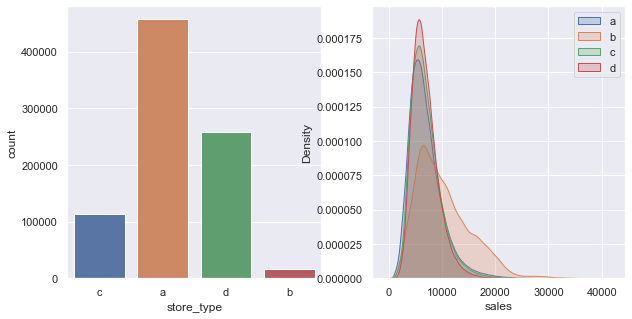

In [46]:
#store_type
plt.subplot(1,2,1)
sns.countplot(df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True)
plt.legend(labels=["a","b","c","d"])

In [47]:
#assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


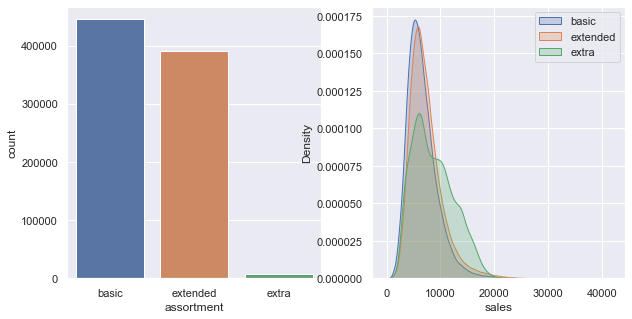

In [48]:
#assortment
plt.subplot(1,2,1)
sns.countplot(df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True)
plt.legend(labels=["basic","extended","extra"])

## 4.2 Análise Bivariada

### **H1**. Lojas com maior sortimentos deveriam vender mais.

**Falso** - Lojas com MAIOR SORTIMENTO vendem MENOS.

A variável assortment vai ser importante para o modelo porque tem um comportamento interessante. Apesar de basic e extended serem bem parecidos, o extra é bem diferente

C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


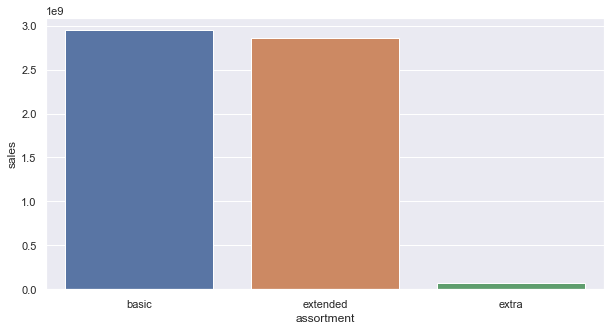

In [49]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(aux1['assortment'],aux1['sales']);

aux1

<AxesSubplot:xlabel='year_week'>

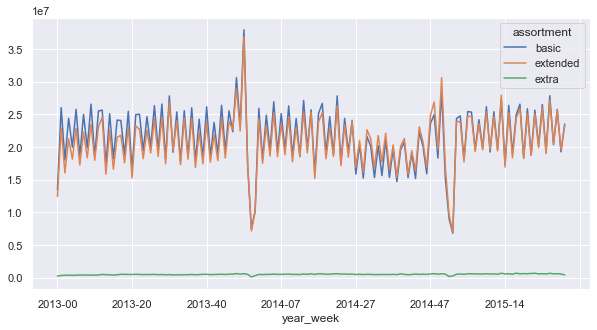

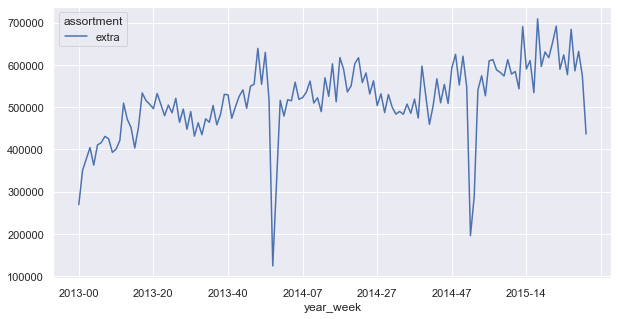

In [50]:
#avaliando a relação do assortment e as vendas no decorrer do tempo
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()

#criando uma tabela e posterior gráfico de valores agrupados que agrega os itens individuais de uma tabela mais extensa em uma ou mais categorias discretas.
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

#avaliando o assortment extra mais de perto
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**Falso** - Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

A variável competition_distance vai ser importante para o modelo porque tem uma correlação com sales não tão proxima de zero. 

<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

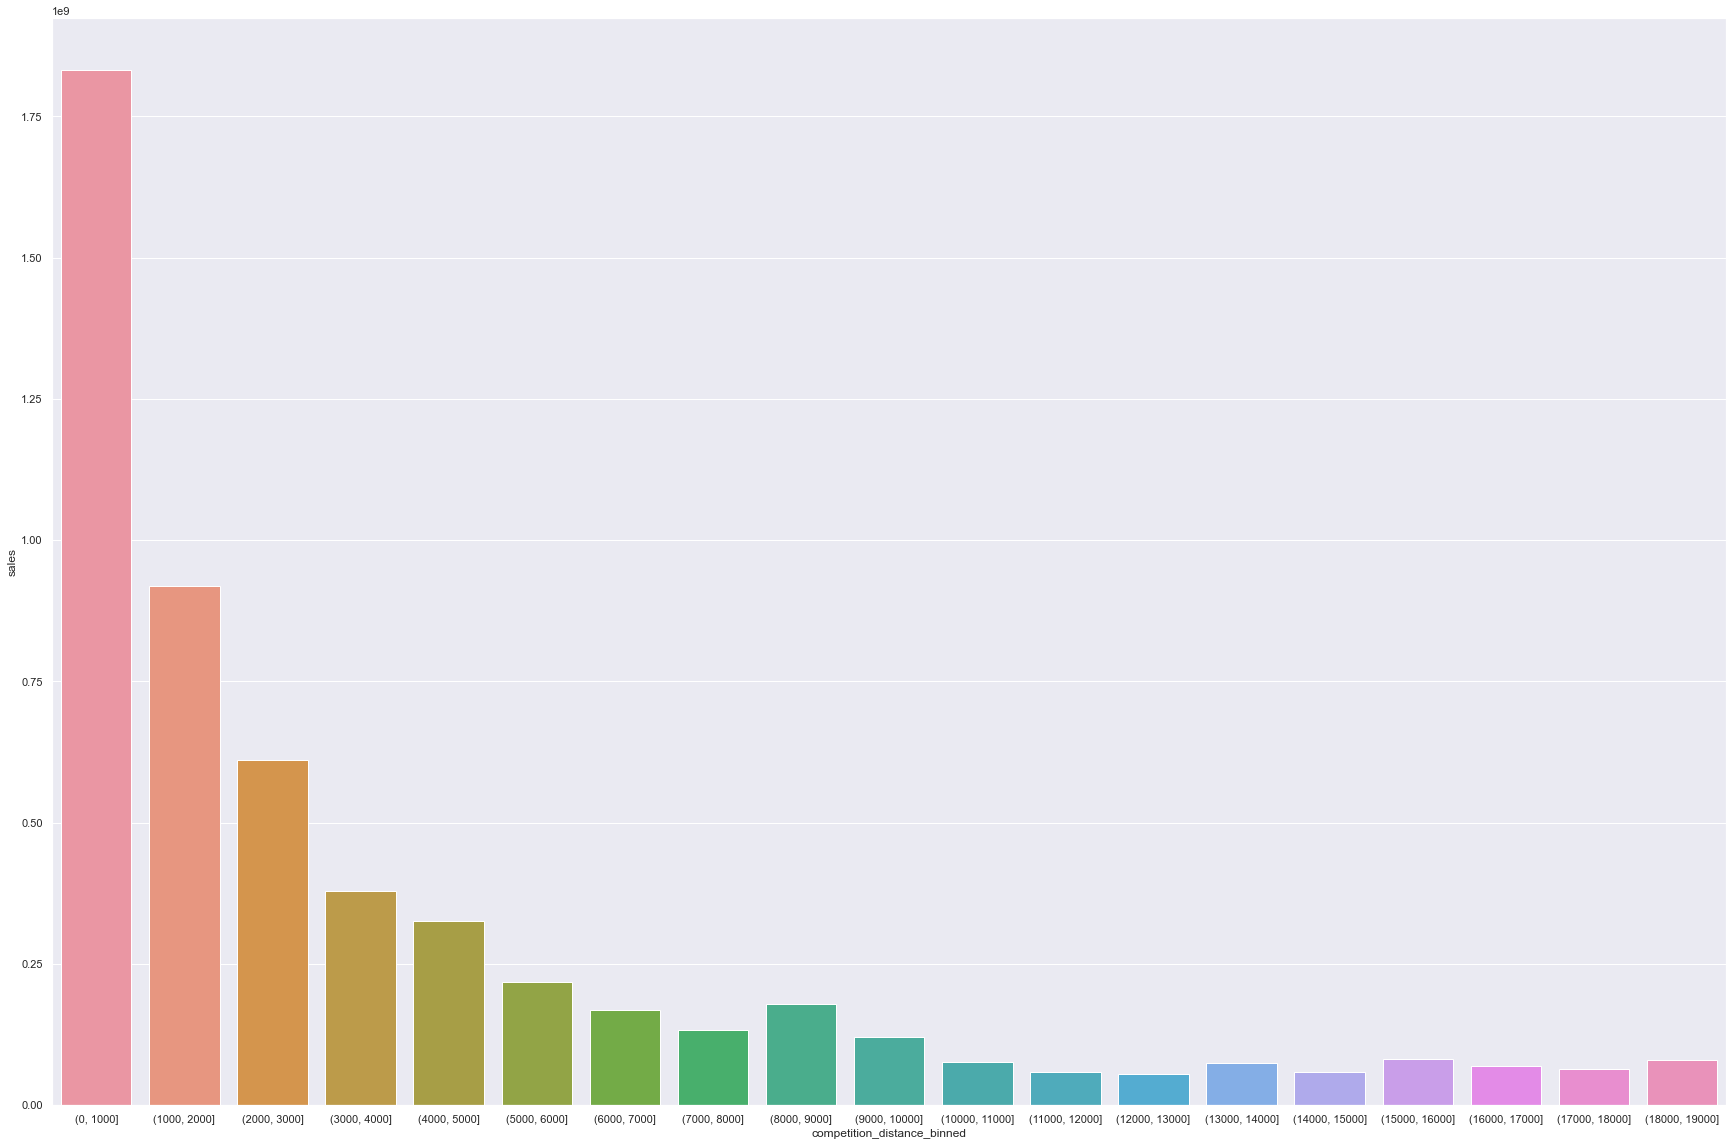

In [51]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#como tem mts distancias diferentes, vou agrupar as distancias de 1000 em 1000
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)

#agrupando
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(30,20))
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
#plt.xticks(rotation=90);

In [52]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
457,8860.0,7185993,"(8000, 9000]"
317,4330.0,4716888,"(4000, 5000]"
518,12920.0,6133846,"(12000, 13000]"
265,3340.0,4429448,"(3000, 4000]"


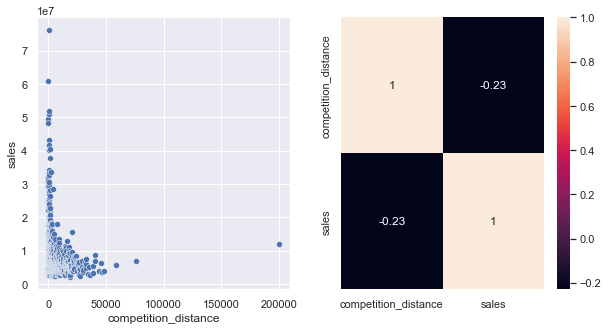

In [53]:
#para entender a distribuição dos valores
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

#gráfico com a correlação entre competition distance e sales
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#quanto mais proximo de 0 mais fraca é a correlação 
#quanto mais proximo de 1 ou -1 mais forte é a correlação

#uma correlação de -0,2 significa que quanto mais distante o competidor está maior a venda

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**Falso** - Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS. 

A variável competion_time_month vai ser importante para o modelo porque tem uma correlação com sales não tão proxima de zero. 

In [54]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competion_since',
       'competion_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

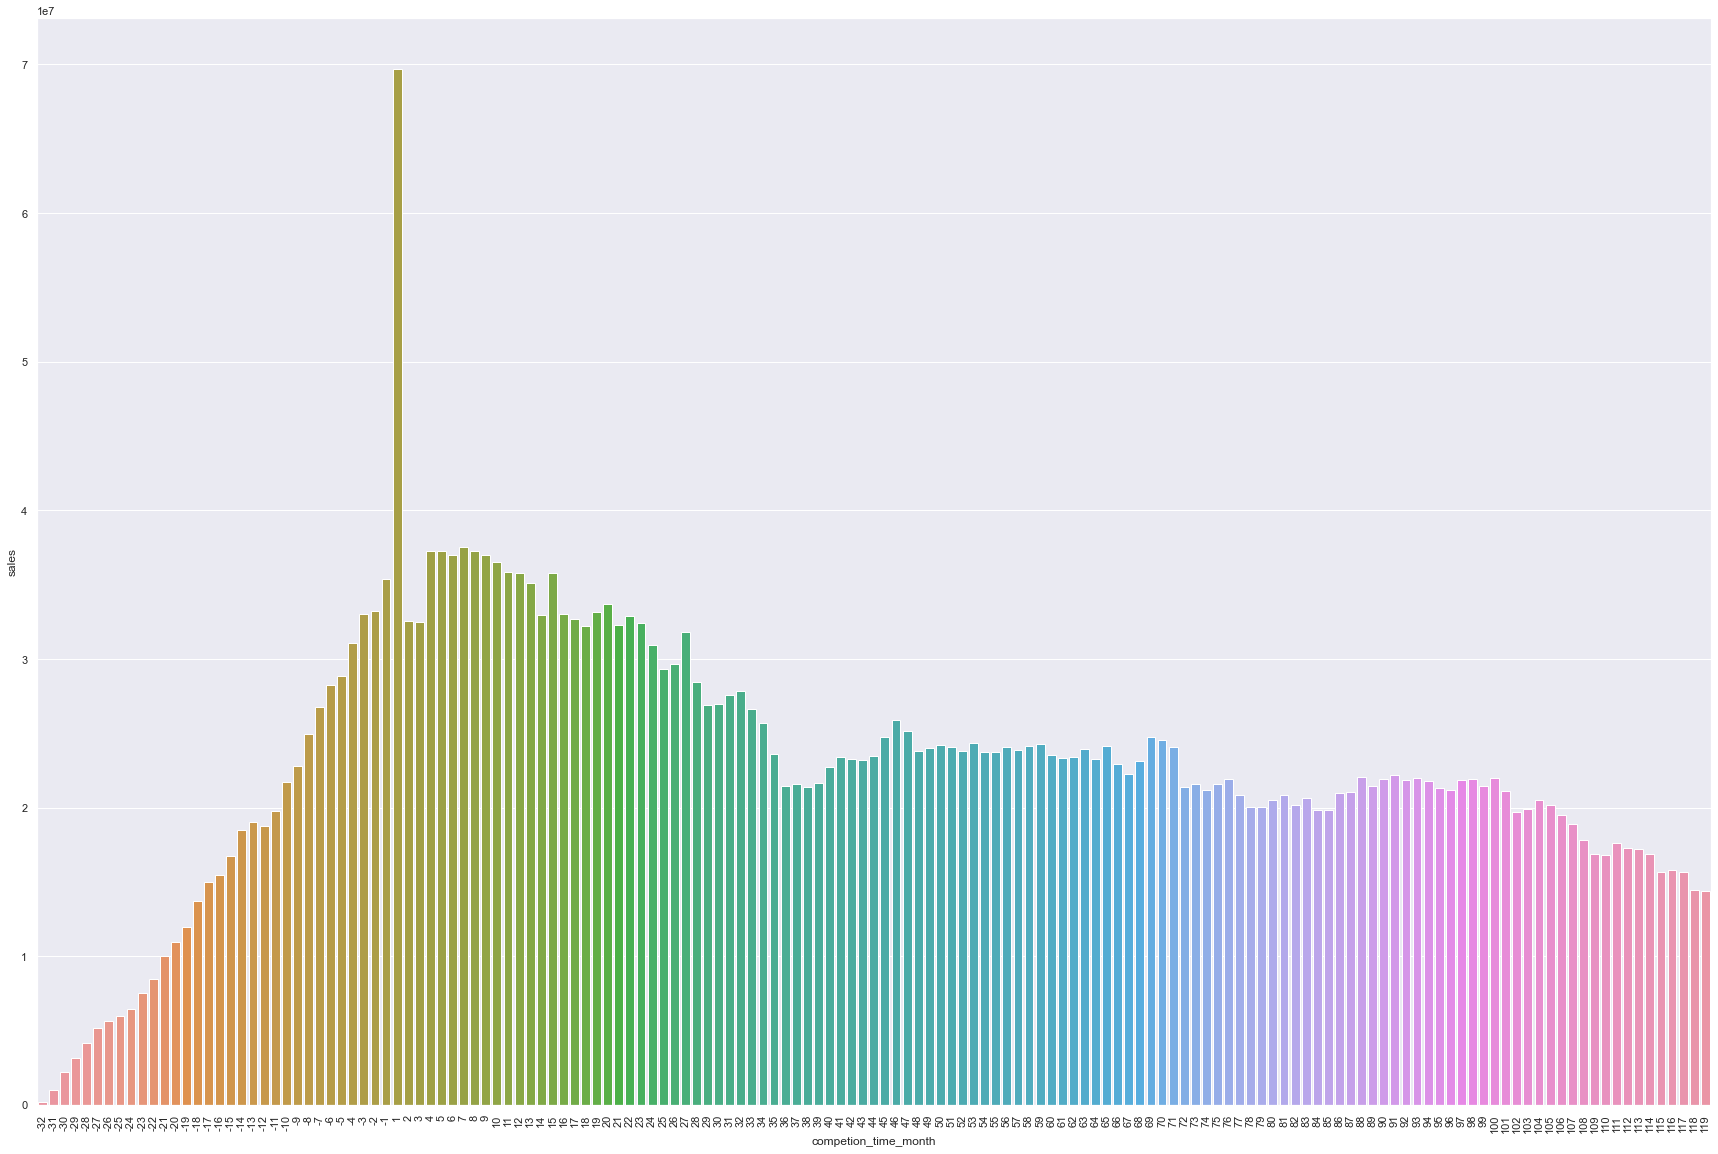

In [55]:
aux1 = df4[['competion_time_month','sales']].groupby('competion_time_month').sum().reset_index()

#a granularidade tá muito grande, então vou fazer um filtro para pegar só os 120 primeiros meses e que começou no msm mes da venda
plt.figure(figsize=(30,20))
aux2 = aux1[(aux1['competion_time_month'] < 120 ) & (aux1['competion_time_month'] != 0)]
sns.barplot(x='competion_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

#quanto mais se aproxima de zero, ou seja, quanto menor o tempo que o competidor inaugurou maior é a venda

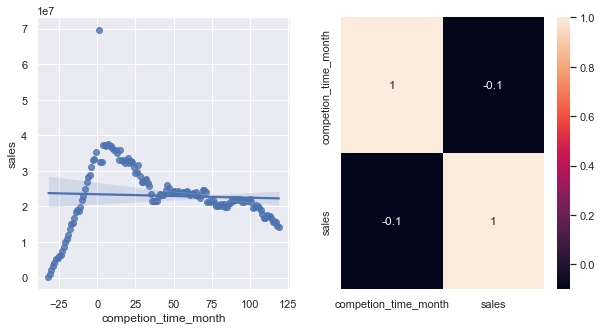

In [56]:
plt.subplot(1,2,1)
aux2 = aux1[(aux1['competion_time_month'] < 120 ) & (aux1['competion_time_month'] != 0)]
sns.regplot(x='competion_time_month',y='sales',data=aux2)

#gráfico com a correlação entre competition distance e sales
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#quanto mais proximo de 0 mais fraca é a correlação 
#quanto mais proximo de 1 ou -1 mais forte é a correlação


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falso** - As vendas são regulares até um certo período, mas depois de um tempo com a promoção ativa percebe-se que as vendas diminuem.
 

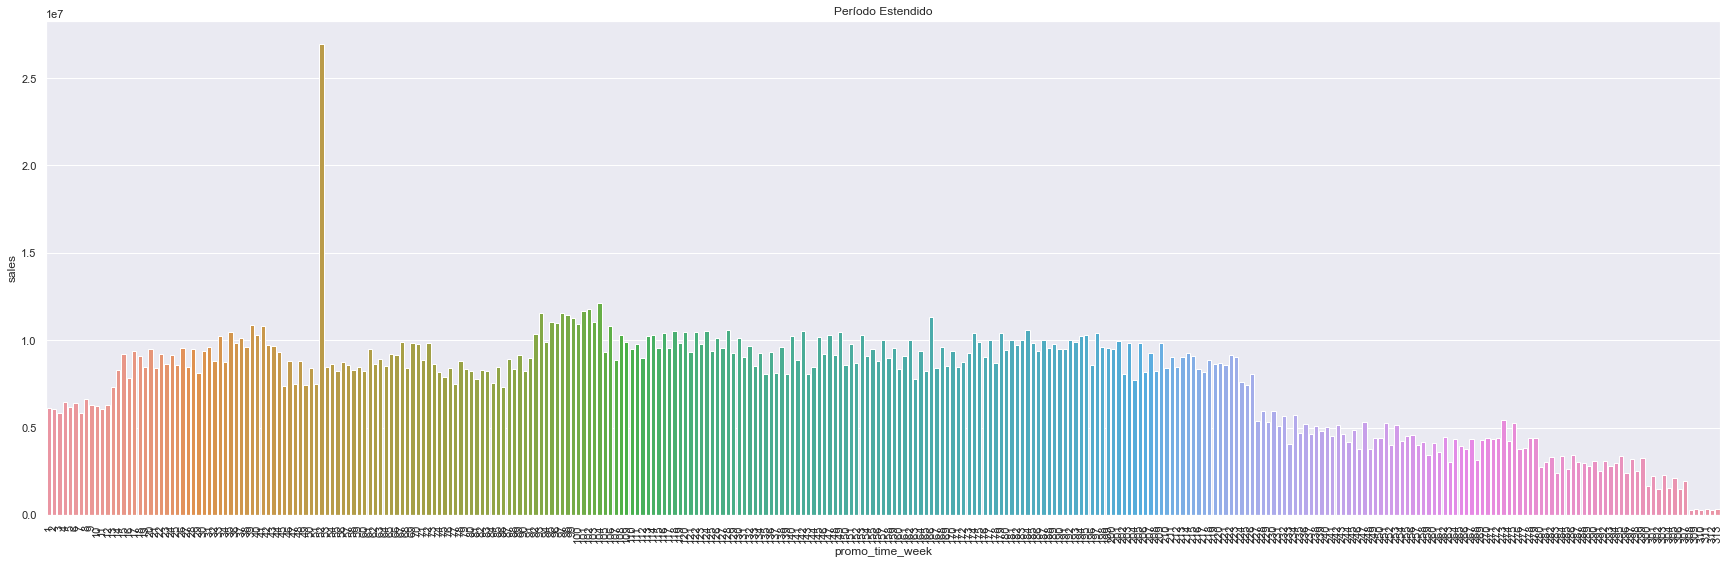

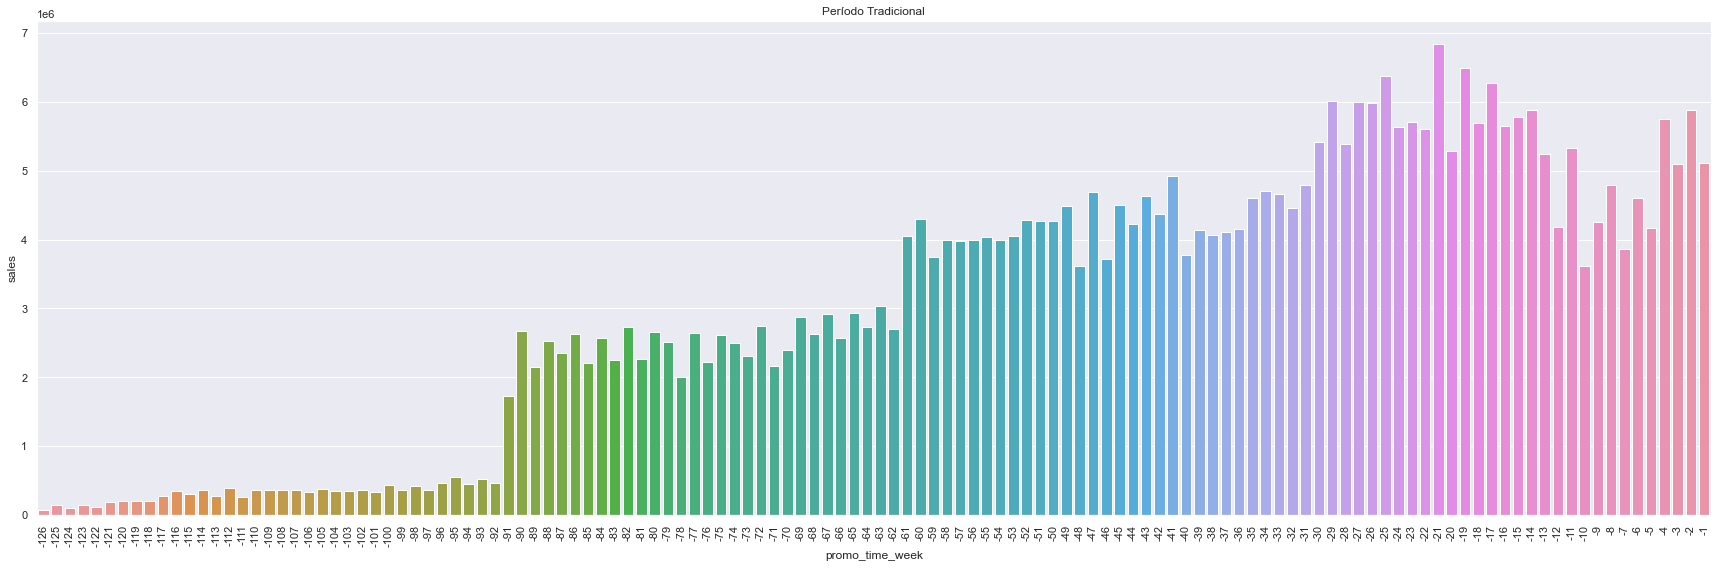

In [57]:
# a data que a promoção estendida começou é a data que a promoção tradional acabou
# a promo time week calcula a diferença entre a data da promoção estendida e a data da venda
# se for positivo significa que a venda foi feita na promoção estendida
# se for negativa significa que a venda foi feita no periodo tradicional da promoção
# vou fazer a separação do dataset para ficar melhor de visualizar
aux1= df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot( x='promo_time_week', y='sales' , data=aux1);

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo estendido
sns.barplot( x='promo_time_week', y='sales' , data=aux2).set(title='Período Estendido');
plt.xticks(rotation=90);


plt.figure(figsize=(30,20))
plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0] #periodo tradicional
sns.barplot( x='promo_time_week', y='sales' , data=aux3).set(title='Período Tradicional');
plt.xticks(rotation=90);


<AxesSubplot:>

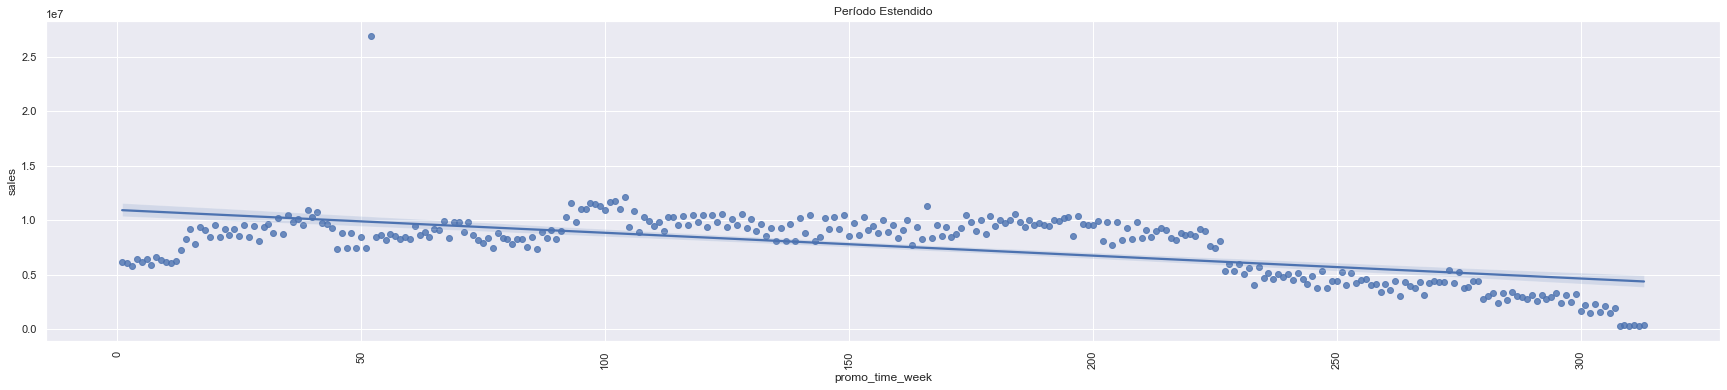

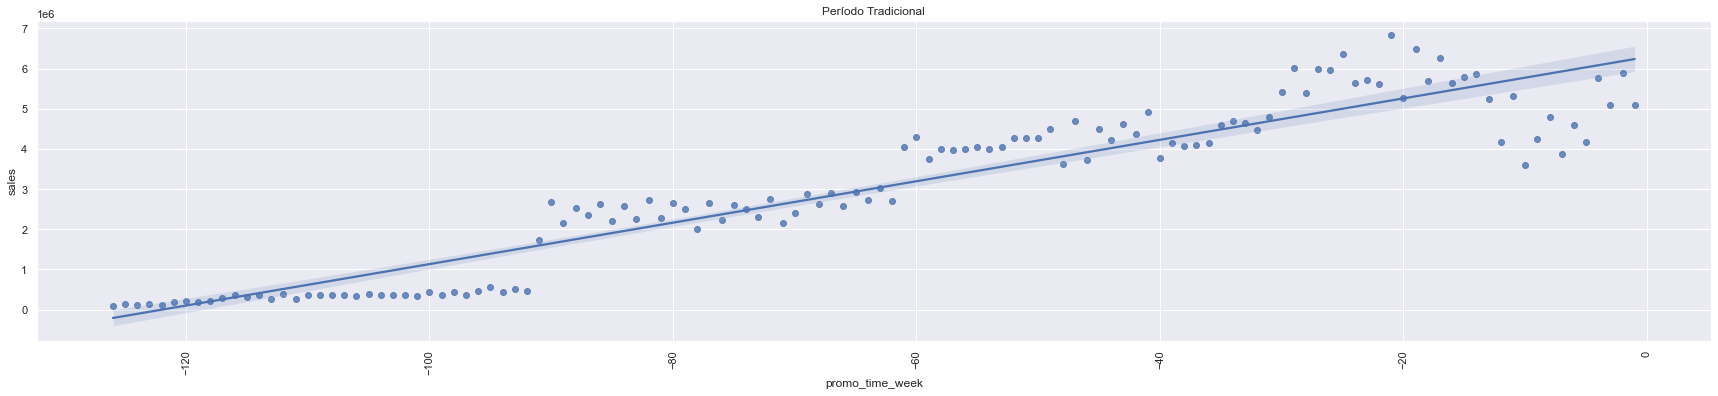

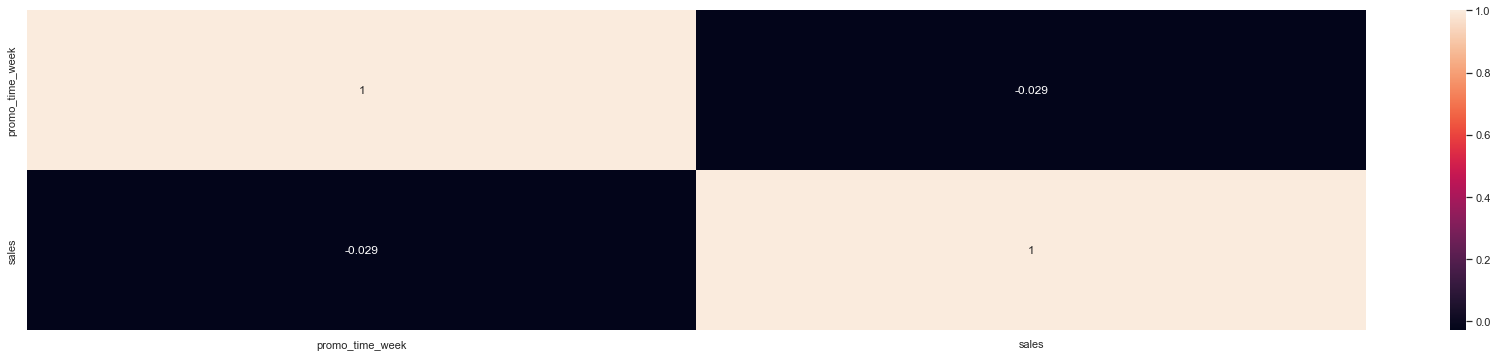

In [58]:
#tendencia
plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
sns.regplot( x='promo_time_week', y='sales' , data=aux2).set(title='Período Estendido');
plt.xticks(rotation=90);

plt.figure(figsize=(30,20))
plt.subplot(3,1,2)
sns.regplot( x='promo_time_week', y='sales' , data=aux3).set(title='Período Tradicional');
plt.xticks(rotation=90);

#força de correlação
plt.figure(figsize=(30,20))
plt.subplot(3,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**Falso** - Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS. 

A variável provavelmente não vai ser importante para o modelo porque ter ou não promoção consecutiva deixa o comportamento muito parecido

In [59]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


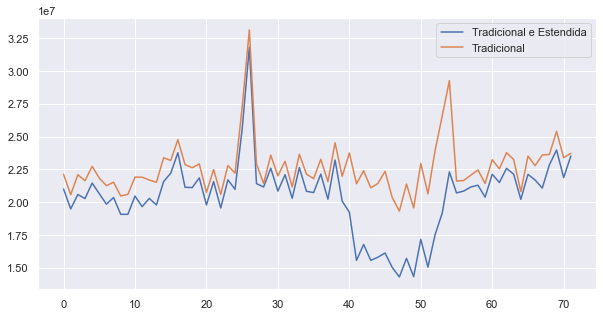

In [60]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Estendida','Tradicional'])

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**Falso** - Lojas ABERTAS DURANTE O NATAL vendem MENOS. 


In [61]:
df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

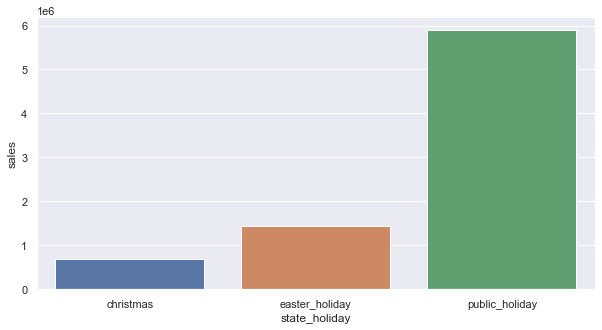

In [62]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data=aux1)

In [63]:
#avaliando se em outros anos teve mais venda
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
aux2

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


<AxesSubplot:xlabel='year', ylabel='sales'>

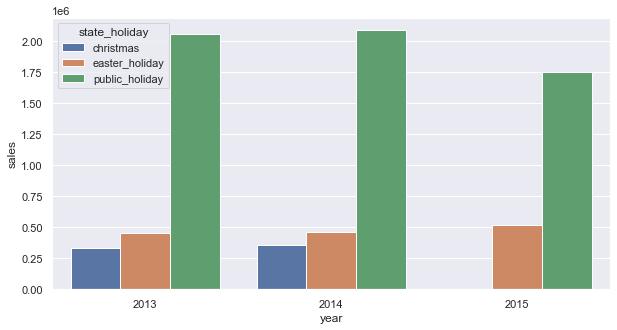

In [64]:
sns.barplot( x ='year',y ='sales', hue='state_holiday', data= aux2)

### **H9.** Lojas deveriam vender mais ao longo dos anos.

**Falso** - Lojas vendem MENOS AO LONGO DOS ANOS. 

Pelos gráficos consegue notar a dependência decrescente entre os anos e as vendas. 

Possui uma correlação bem grande negativamente de -0,92, ou seja, assim que os anos vão avançando as vendas vão caindo. Mas é importante notar que os dados não contem o ano de 2015 completo, então realmente vai ter menos vendas. 

In [65]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

<AxesSubplot:>

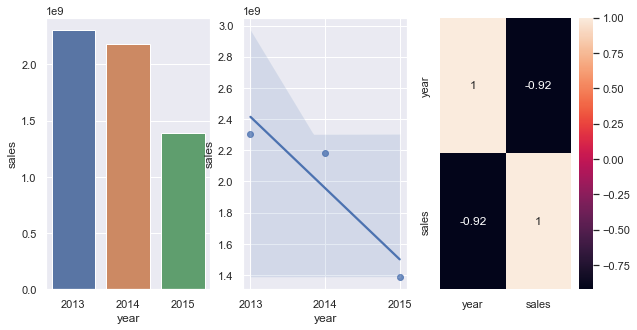

In [66]:
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

### **10.** Lojas deveriam vender mais no segundo semestre do ano.

**Verdadeiro** - Lojas vendem MAIS no segundo semestre do ano. 

As vendas não tem muita variação no decorrer dos meses, mas em dezembro as vendas são bem maiores. A correlação entre as variáveis não é tão alta. 

<AxesSubplot:>

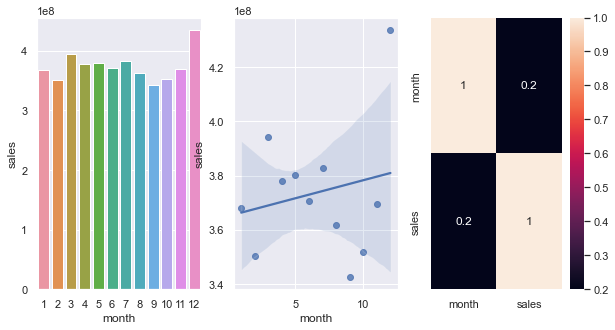

In [67]:
#tirando os dados de 2015 porque o ano não está completo
aux = df4[df4['year'] != 2015]

aux1 = aux[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

### **11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeiro** - Lojas vendem MAIS depois do dia 10 de cada mês.

É importante notar que a separação after/before_10_days não é homogênia porque tem mais dias depois do dia 10 do que antes. Mas notou-se que as vendas depois do dia 10 são realmente maiores.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

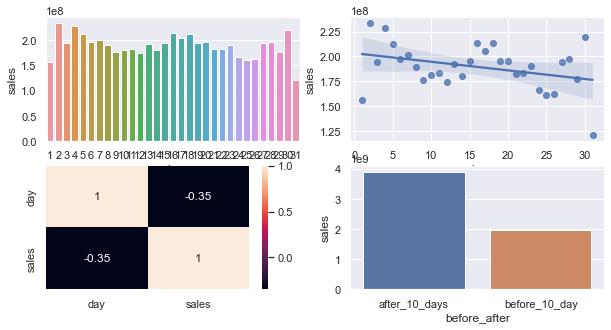

In [68]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y= 'sales', data =  aux1)

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

#criando um coluna que avalia se o dia é anterior ao dia 10
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data= aux2)

### **H12.** Lojas deveriam vender menos aos finais de semana.

**Verdadeiro** - Lojas vendem MENOS aos finais de semana.

<AxesSubplot:>

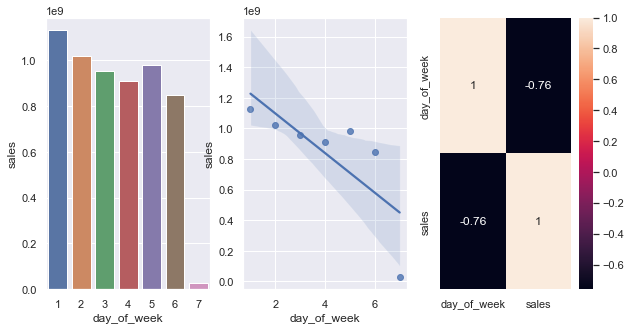

In [69]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

#dia 1 é segunda e 7 é domingo

### **H13.** Lojas deveriam vender menos durante os feriados escolares

**VERDADEIRO** - Lojas vendem MENOS durante os feriados, exceto nos meses de Julho e Agosto. 

Em Julho por ser férias as vendas quase se equiparam. E em Agosto as vendas são maiores nos períodos de feriado escolar. 

<AxesSubplot:xlabel='month', ylabel='sales'>

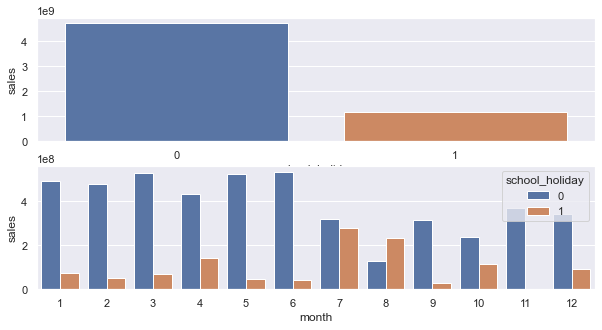

In [70]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

#avaliando por mês
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data=aux2)

#school holiday igual a zero significa que é aula normal, igual a 1 é feriado escolar


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

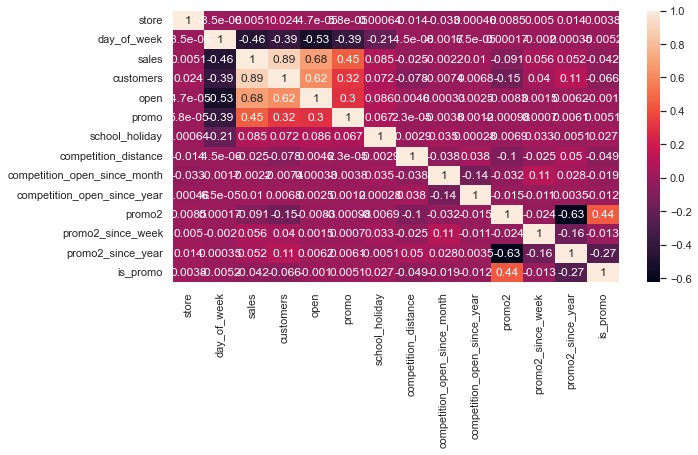

In [71]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#quanto mais perto da cor preta maior é a correlação negativa 
#e quanto mais perto do branco maior é a correlação positiva 

In [72]:
from tabulate import tabulate
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Media'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
['H13', 'Verdadeira', 'Baixa']
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Media
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa
H13          Verdadeira   Baixa


### 4.3.2 Categorical Attributes

In [73]:
a = df4.select_dtypes(include='object')
a

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


Para fazer a correlação entre os atributos categoricos vou usar o **método cramer v**. Essa correlação vai de 0 a 1, não existe  correlação negativa, quanto mais perto do 0 menor a correlação. 

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V



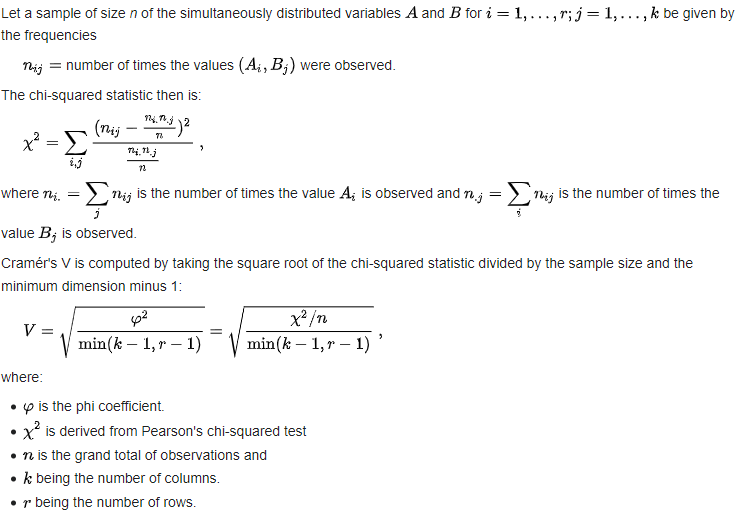

In [74]:
Image(r"C:\Users\laais\CDS_DS_em_produção\cramer v.png")

In [75]:
#tabela de contingencia/confusing matrix (cm)
#pega duas variaveis categoricas q eu queria fazer a correlação
cm = pd.crosstab( a['state_holiday'], a['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [76]:
chi2 = ss.chi2_contingency(cm)[0]
chi2

n = cm.sum()

r, k = cm.shape

In [77]:
v = np.sqrt( (chi2/n) / (min(k-1, r-1)))
v

0.07106457093267678

In [78]:
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    return np.sqrt( (chi2/n) / (min(k-1, r-1)))

In [79]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106457093267678

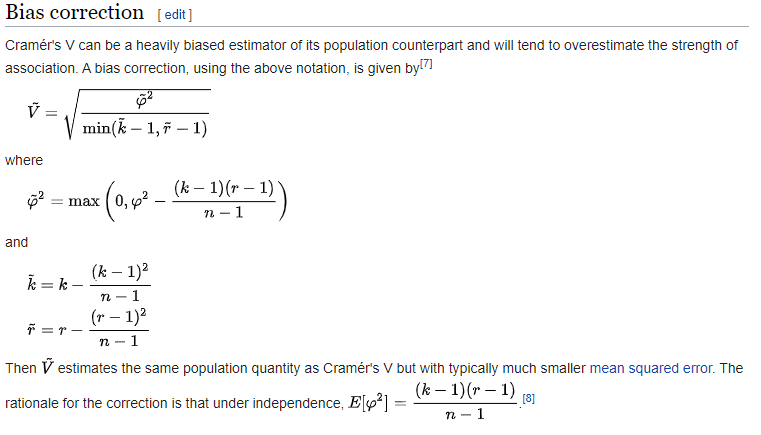

In [80]:
# o método de cramer v pode subestimar o valor, então é necessario fazer uma correção na fórmula
Image(r"C:\Users\laais\CDS_DS_em_produção\cramer v2.png")

In [81]:
#função corrigida
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [82]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

In [83]:
#somente dados categoricos
a = df4.select_dtypes(include='object')

#calculando cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#dataset final
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

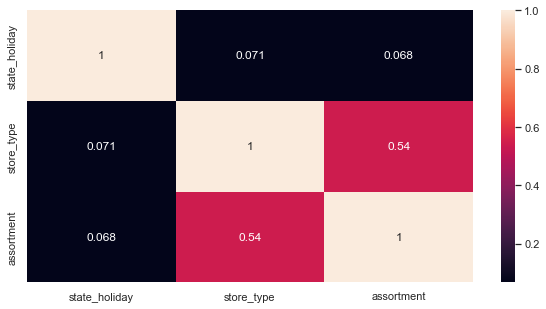

In [84]:
sns.heatmap( d, annot=True )

# 5.0 PASSO 05 - Data Preparation

In [85]:
df5 = df4.copy()

## 5.1 Normalização

Não tem nenhuma variável que segue uma distribuição normal então não faz a normalização 

## 5.2 Rescaling

In [86]:
#identificando quais variáveis vou aplicar o rescaling
a = df5.select_dtypes(include= ['int64', 'float64','int32'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competion_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laais\anaconda3\lib\si

<AxesSubplot:xlabel='year'>

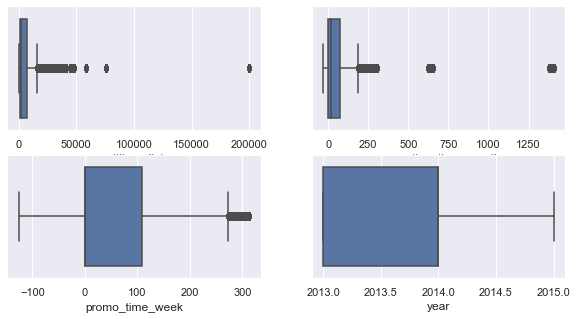

In [87]:
#vou usar as variaveis competition_distance, year, competition time month, promo time week

#avaliando quais tem outliers
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(df5['competion_time_month'])

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'])

plt.subplot(2,2,4)
sns.boxplot(df5['year'])

In [88]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

In [89]:
rs = RobustScaler()
mms = MinMaxScaler()

#Técnica Robust Scaler
#criando a msm variavel mas em uma nova escala
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competion_time_month'] = rs.fit_transform(df5[['competion_time_month']].values)

#Técnica Min-Max Scaler:
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3 Transformação

In [90]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competion_since,competion_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [91]:
df5[['state_holiday','store_type','assortment']]

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic
...,...,...,...
1016776,public_holiday,b,basic
1016827,public_holiday,b,extra
1016863,public_holiday,b,extra
1017042,public_holiday,b,extra


### 5.3.1 Encoding

In [92]:
from sklearn.preprocessing import LabelEncoder

In [93]:
#variaveis categoricas: state_holiday , store_type e assortment

#state_holiday - One Hot Encoding
#cria uma coluna pra cada tipo colocando 1 ou 0
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
#substitui a categoria por número
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
#substitui a categoria por número de forma ordenada
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [94]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competion_since,competion_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Responde Variavel Transformation

C:\Users\laais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

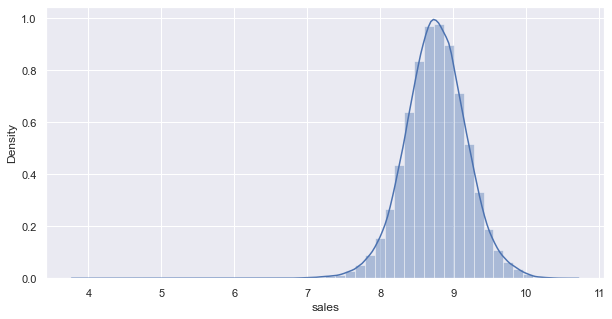

In [95]:
#aplicando o log na variavel resposta
df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

In [96]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competion_since',
       'competion_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day'],
      dtype='object')

### 5.3.3 Nature Transformation

In [97]:
#separando quais variáveis tem natureza ciclica 
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52)))


#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7)))


# 6.0 PASSO 06 - Feature Selection

In [98]:
df6 = df5.copy()

## 6.1 Split dataframe into training and teste dataset

In [99]:
#apagando as variaveis mães/originais que fizemos as derivadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competion_since','year_week']

df6 = df6.drop(cols_drop, axis=1)

In [100]:
#dataframe para treinar o modelo 
#vai pegar todos os dados menos da ultimas 6 semanas

#primeira data do dataset
prim_datas = df6[['store','date']].groupby('store').min().reset_index()

#ultima data do dataset
ult_datas = df6[['store','date']].groupby('store').max().reset_index()

#tirando 6 semanas da data final
data = ult_datas['date'][0] - datetime.timedelta(days=6*7)
data

Timestamp('2015-06-19 00:00:00')

In [101]:
#training dataset
#filtrando os dados anteriores a essa data
#X_train = df6[df6['date'] < data]
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

In [102]:
#test dataset
#datafram para fazer o teste e medir a acurácia 
#dados das ultimas 6 semanas
X_test = df6[df6['date'] >= data]
y_test = X_test['sales']

In [103]:
print('Data Min de Training: {}'.format(X_train['date'].min()))
print('Data Max de Training: {}'.format(X_train['date'].max()))

print('Data Min de Test: {}'.format(X_test['date'].min()))
print('Data Max de Teste: {}'.format(X_test['date'].max()))

Data Min de Training: 2013-01-01 00:00:00
Data Max de Training: 2015-06-18 00:00:00
Data Min de Test: 2015-06-19 00:00:00
Data Max de Teste: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [104]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [105]:
#training and test dataset for boruta
#pegando só os valores do dataset pqe o modelo não aceita dataframe
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

#definindo RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#primeiro parametro é o tipo de modelo, no caso vou usar random forest 
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [106]:
#vendo qual coluna vai ser relevante, o support traz o indice da coluna
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#compararando as colunas originais com as colunas que o boruta selecionou
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#cols_selected_boruta

In [107]:
#comparando o que selecionei como relevante e o que o boruta selecionou

print( tabulate( tab, headers='firstrow' ) )

#print(cols_selected_boruta)

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Media
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa
H13          Verdadeira   Baixa


## 6.3 Manual Feature Selection

In [108]:
#colocando em uma variavel para não precisar rodar novamente
#adicionei os sen/cos 
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competion_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

#colunas para adicionar de novo
feat_to_add = ['date','sales']

#features final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 PASSO 07 - Machine Learning Modelling

In [109]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series data preparation
#X_train que é o dataset completo mas somente com as colunas selecionadas pelo boruta
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [110]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [111]:
#função que calcula a performance dos modelos
def ml_error(model_name, y, yhat):
    """model_name: nome do modelo
       y:valores reais
       yhat: valores preditos/ estimativas
    """
    #calculo de 3 tipos de erros:
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

In [112]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
#previsão a partir da media de venda de cada uma das lojas
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales': 'predictions'})
#anexando ao conjunto de dados original
aux1 = pd.merge(aux1, aux2, how= 'left', on= 'store')
yhat_baseline = aux1['predictions']

#performance
#fizemos o treino das vendas usando o log dos valores, entao aplica o exponencial para voltar para o original
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [113]:
from sklearn.linear_model import LinearRegression, Lasso

In [114]:
#model
#vai treinar o modelo
lr = LinearRegression().fit( x_train, y_train)

#prediction
#fazendo a predição com os dados de teste
yhat_lr = lr.predict( x_test)

#performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [115]:
model = LinearRegression()
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', model, verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98


## 7.3 Linear Regression Regularized Model - Lasso

In [116]:
#model
#vai treinar o modelo
#o alpha é um fator multiplicativo dos pesos para ficar dentro de um range específico
lrr = Lasso( alpha = 0.01).fit( x_train, y_train)

#prediction
#fazendo a predição com os dados de teste
yhat_lrr = lrr.predict( x_test)

#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [117]:
model = Lasso()
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', model, verbose = False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2207.33 +/- 184.53,0.33 +/- 0.01,3116.2 +/- 286.66


## 7.4 Random Forest Regressor

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
#model
#vai treinar o modelo
# n_estimators -> quantas arvores aleatorias ele vai criar
rf = RandomForestRegressor( n_estimators = 100, n_jobs=1, random_state= 42).fit( x_train, y_train)

#prediction
#fazendo a predição com os dados de teste
yhat_rf = rf.predict( x_test)

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.865295,0.099845,1009.761326


### 7.4.1 Random Forest Regressor - Cross Validation

In [120]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True )
rf_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,746.71 +/- 133.01,0.11 +/- 0.02,1126.57 +/- 202.87


## 7.5 XGBoost Regressor

In [121]:
import xgboost as xgb

In [122]:
#model
#vai treinar o modelo
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 100,
                              eta = 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytee = 0.9).fit( x_train, y_train)

#prediction
#fazendo a predição com os dados de teste
yhat_xgb = model_xgb.predict( x_test)

#performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[20:16:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


### 7.5.1 XGBoost Regressor - Cross Validation

In [123]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
xgb_result_cv


KFold Number: 4
[20:18:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 3
[20:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 2
[20:22:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 1
[20:24:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6795.46 +/- 335.97,0.95 +/- 0.0,7416.9 +/- 389.25


### Cross-Validation

In [124]:
#subtraindo 6 semanas do dataset
#data inicio da validação
validation_start_date = x_training['date'].max() - datetime.timedelta( days=1*6*7)
#data fim da validação
validation_end_date = x_training['date'].max() - datetime.timedelta( days=0*6*7)

#filtrando o dataset para pegar os dados de treino (que começam do inicio ate os dados de validação)
training = x_training[x_training['date'] < validation_start_date ]
validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

#dataset de treino e validação
xtraining = training.drop(['date','sales'], axis=1)
ytraining = training['sales']

xvalidation = validation.drop(['date','sales'], axis=1)
yvalidation= validation['sales']

#model
LinearRegression().fit( xtraining, ytraining)

#prediction
yhat_lr = lr.predict( xvalidation)

#performance
lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1973.888013,0.285668,2823.770056


In [125]:
#gerenalizando

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    #lista para calcular a performance 
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #data inicio da validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        #data fim da validação
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        #filtrando o dataset para pegar os dados de treino (que começam do inicio ate os dados de validação)
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #dataset de treino e validação
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation= validation['sales']

        #model
        m = model.fit( xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #guardando a performance de cada iteração
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)
                        }, index=[0])

In [126]:
model = LinearRegression()
cross_validation(x_training, 5, 'Linear Regression', model, verbose=False)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98


## 7.6 Compare Regressor 

### 7.6.1 Single Performance

In [127]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])

#ordenando de acordo com o erro
modelling_result.sort_values('RMSE')

#Isso demonstra que o fenômeno que estou tentando modelar que é a previsão de vendas da loja da rossman 
# não é um problema simples, é um problema complexo, então modelos lineares que são modelos mais simples
# não funcionam muito bem. Nota-se que a Random Forest funciona bem.

#esses valores não representam o valor real da perfomance dos modelos, 
# porque só separamos as ultimas 6 semanas para fazer o teste, o ideal é pegar varias semanas em periodos diferentes
# para ter uma amostra melhor. Essa atividade é chamada de cross-validation

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.865295,0.099845,1009.761326
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735
0,Linear Regression,1973.888013,0.285668,2823.770056
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


### 7.6.2 Real Performance - Cross Validation

In [128]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])

#ordenando de acordo com o erro
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,746.71 +/- 133.01,0.11 +/- 0.02,1126.57 +/- 202.87
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98
0,Linear Regression - Lasso,2207.33 +/- 184.53,0.33 +/- 0.01,3116.2 +/- 286.66
0,XGBoost Regressor,6795.46 +/- 335.97,0.95 +/- 0.0,7416.9 +/- 389.25


In [129]:
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98
0,Linear Regression - Lasso,2207.33 +/- 184.53,0.33 +/- 0.01,3116.2 +/- 286.66
0,Random Forest Regressor,746.71 +/- 133.01,0.11 +/- 0.02,1126.57 +/- 202.87
0,XGBoost Regressor,6795.46 +/- 335.97,0.95 +/- 0.0,7416.9 +/- 389.25


# 8.0 PASSO 08 - Hyperparameter Fine Tuning

## 8.1 Random Search

- **Random Search**: define valores para cada um dos hiperparâmetros aleatoriamente.
    - em cada iteração ele testa aleatoriamente com os valores que você propôs.

In [130]:
#parametros que serão usados
param = {
    'n_estimators': [1500,1700,3000,3500],
    'eta': [0.01,0.03],
    'max_depth': [3,5,9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3,0.7,0.9],
    'min_child_weight': [3,8,15]
}

max_eval = 5

In [131]:
"""final_result =  pd.DataFrame()

#escolhendo os parametros aleatoriamente
for i in range(max_eval):
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)

    #model
    #vai treinar o modelo
    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                                  n_estimators = hp['n_estimators'],
                                  eta = hp['eta'],
                                  max_depth = hp['max_depth'],
                                  subsample = hp['subsample'],
                                  colsample_bytee = hp['colsample_bytee'],
                                  min_child_weight = hp['min_child_weight'])

    #performance
    result = cross_validation(x_training, kfold = 5, model_name = 'XGBoost Regressor', model = model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])"""

"final_result =  pd.DataFrame()\n\n#escolhendo os parametros aleatoriamente\nfor i in range(max_eval):\n    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }\n    print(hp)\n\n    #model\n    #vai treinar o modelo\n    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',\n                                  n_estimators = hp['n_estimators'],\n                                  eta = hp['eta'],\n                                  max_depth = hp['max_depth'],\n                                  subsample = hp['subsample'],\n                                  colsample_bytee = hp['colsample_bytee'],\n                                  min_child_weight = hp['min_child_weight'])\n\n    #performance\n    result = cross_validation(x_training, kfold = 2, model_name = 'XGBoost Regressor', model = model_xgb, verbose=False)\n    final_result = pd.concat([final_result, result])"

## 8.2 Final Model

In [132]:
#parametros previstos como os melhores
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3
}

In [139]:
#model
#vai treinar o modelo
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'],
                              eta = param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytee = param_tuned['colsample_bytee'],
                              min_child_weight = param_tuned['min_child_weight']).fit( x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[21:44:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



AttributeError: module 'numpy' has no attribute 'expml'

In [140]:
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.982621,0.114586,1090.615129


In [142]:
import pickle

In [144]:
#pickle.dump( model_xgb_tuned, open(''))

In [1]:
from sklearn.metrics import mean_percentage_error

ImportError: cannot import name 'mean_percentage_error' from 'sklearn.metrics' (C:\Users\laism\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

# 9.0 PASSO 09 - Tradução e Interpretação do erro

In [147]:
df9 = X_test[ cols_selected_boruta_full]

#reescale -> voltando para a escala original
df9['sales'] = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned)

C:\Users\laais\AppData\Local\Temp/ipykernel_11944/261112945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'])
C:\Users\laais\AppData\Local\Temp/ipykernel_11944/261112945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned)


## 9.1 Business Performance

In [151]:
#soma das predições para saber quanto de dinheiro vai entrar usando esse modelo
#agrupando por loja porque quer o faturamento por loja
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index()
df9_aux1 = df9_aux1.rename(columns={0: 'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index()
df9_aux2 = df9_aux2.rename(columns={0: 'MAPE'})

#juntando
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')
df92

,store,predictions,MAE,MAPE
0,1,169443.640625,317.324397,0.073807
1,2,179460.015625,443.000937,0.088515
2,3,270797.218750,718.829801,0.098910
3,4,353223.062500,750.696606,0.072531
4,5,167037.984375,324.333318,0.072094
...,...,...,...,...
1110,1111,184384.734375,679.683171,0.152541
1111,1112,341137.843750,1006.238598,0.123120
1112,1113,249598.687500,557.057485,0.087244
1113,1114,788804.062500,1954.054001,0.084506


In [152]:
#cenarios possiveis
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#ordenando as colunas
df92 = df92[['store','predictions','worst_scenario', 'best_scenario', 'MAE','MAPE']]
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
725,726,420131.187500,419318.259937,420944.115063,812.927563,0.076799
853,854,241618.000000,240786.927101,242449.072899,831.072899,0.150131
432,433,224112.609375,223587.383358,224637.835392,525.226017,0.109863
824,825,189432.156250,188968.013645,189896.298855,464.142605,0.089389


In [153]:
#lojas com o erro mt grande
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,109354.000000,105983.438823,112724.561177,3370.561177,0.607991
908,909,224585.750000,216787.546599,232383.953401,7798.203401,0.515880
875,876,195455.906250,191387.553244,199524.259256,4068.353006,0.328635
285,286,164656.531250,163870.336083,165442.726417,786.195167,0.292118
901,902,190099.296875,188958.991442,191239.602308,1140.305433,0.284967


<AxesSubplot:xlabel='store', ylabel='MAPE'>

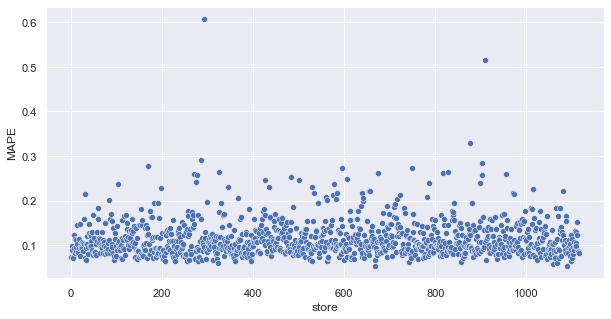

In [154]:
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [157]:
df93 = df92[['predictions','worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Scenario',  0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$287,097,984.00"
1,worst_scenario,"R$286,246,315.42"
2,best_scenario,"R$287,949,684.80"


## 9.3 Machine Learning Performance

In [158]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\laais\AppData\Local\Temp/ipykernel_11944/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\laais\AppData\Local\Temp/ipykernel_11944/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\laais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\laais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

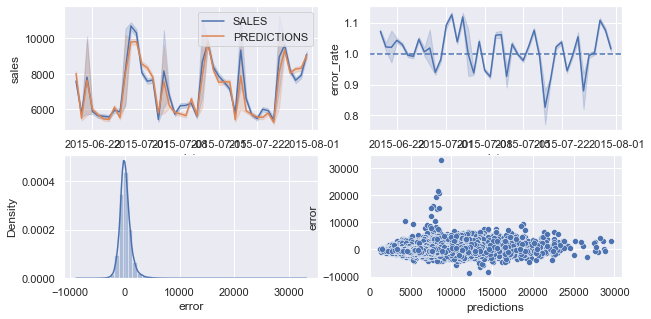

In [160]:
#gráfico das predições ao longo do tempo
plt.subplot(2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

#gráfico da predição dividido pelas vendas, ou seja, qual a porcentagem das predições em relação as vendas
#uma predição perfeita seria uma linha no 1. 
#Se a variação for acima do 1 tem um superestimação, abaixo do 1 uma subestimação, as predições estão abaixo das vendas
plt.subplot(2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1,linestyle='--')

#distribuição dos erros
#a distrubuição é proxima da normal
plt.subplot(2,2,3)
sns.distplot(df9['error'])

#é usado para fazer analise de resudo, para ver quais são os pontos fracos do modelo para melhorar a acurâcia
#o ideal é que a distribuição dos erros fiquem dentro de um tubo
plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])